# Text Mining & Search
Authors
- Alexandre Crivellari
- Andrea Muscio

# Introduction

[TO DO]

# Workspace setting

## Dependencies

In [11]:
#%pip install pandas numpy matplotlib seaborn scikit-learn
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

## Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset upload and exploration

In [2]:
# Define the column names
columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 
           'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 
           'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Read the TSV files
train_df = pd.read_csv('train.tsv', sep='\t', names=columns)
valid_df = pd.read_csv('valid.tsv', sep='\t', names=columns)
test_df = pd.read_csv('test.tsv', sep='\t', names=columns)

# Display the first few rows of the training data
train_df.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [3]:
print(train_df.columns)

Index(['id', 'label', 'statement', 'subject', 'speaker', 'job_title',
       'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context'],
      dtype='object')


id                      0
label                   0
statement               0
subject                 0
speaker                 0
job_title               0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
label_encoded           0
statement_length        0
total_statements        0
dtype: int64
label
half-true      0.206445
false          0.194824
mostly-true    0.191602
true           0.163672
barely-true    0.161523
pants-fire     0.081934
Name: proportion, dtype: float64


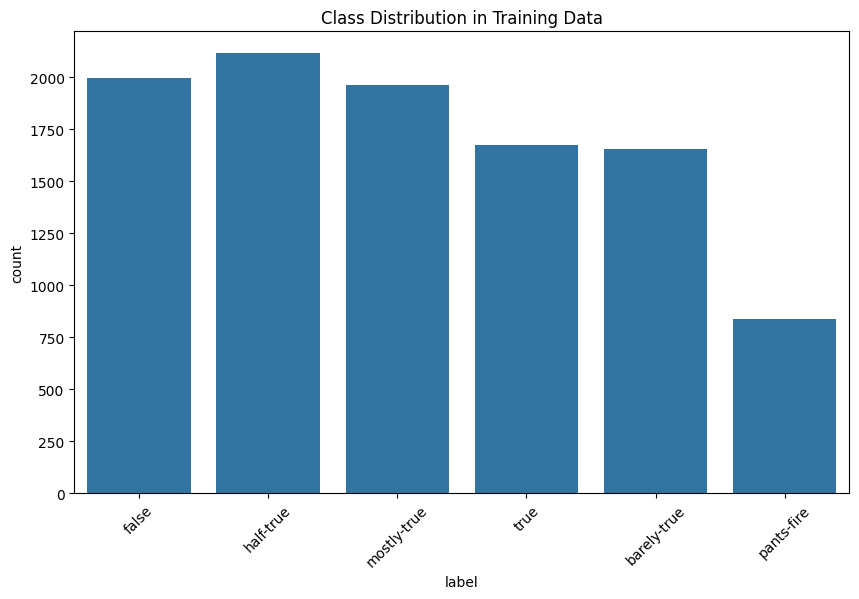

In [9]:
# Check for missing values
print(train_df.isnull().sum())

# Handle missing values (if any)
train_df = train_df.fillna('unknown')
valid_df = valid_df.fillna('unknown')
test_df = test_df.fillna('unknown')

# Handle missing values
categorical_columns = ['subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'context']
numeric_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']

# For categorical columns, fill with 'Unknown' instead of 'unknown'
for col in categorical_columns:
    train_df[col] = train_df[col].fillna('Unknown')
    valid_df[col] = valid_df[col].fillna('Unknown')
    test_df[col] = test_df[col].fillna('Unknown')

# For numeric columns, ensure they are numeric and fill with median
for col in numeric_columns:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
    valid_df[col] = pd.to_numeric(valid_df[col], errors='coerce')
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')
    
    median_value = train_df[col].median()
    train_df[col] = train_df[col].fillna(median_value)
    valid_df[col] = valid_df[col].fillna(median_value)
    test_df[col] = test_df[col].fillna(median_value)

# Encode labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['label'])
valid_df['label_encoded'] = le.transform(valid_df['label'])
test_df['label_encoded'] = le.transform(test_df['label'])

# Display class distribution
print(train_df['label'].value_counts(normalize=True))

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=45)
plt.show()

## Feature Engineering

In [10]:
# Step 2: Feature Engineering (updated)

# Create a feature for statement length
train_df['statement_length'] = train_df['statement'].str.len()
valid_df['statement_length'] = valid_df['statement'].str.len()
test_df['statement_length'] = test_df['statement'].str.len()

# Aggregate count features
count_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 
                 'mostly_true_counts', 'pants_on_fire_counts']

train_df['total_statements'] = train_df[count_columns].sum(axis=1)
valid_df['total_statements'] = valid_df[count_columns].sum(axis=1)
test_df['total_statements'] = test_df[count_columns].sum(axis=1)

# (Task 1a) Text Classification

Single-Label Multi-Class, non bello

## Model Selection and Training

[Descrizione di cosa faremo]

### Traditional ML Model (Random Forest)

[Descrizione del modello]

Random Forest Performance:
              precision    recall  f1-score   support

        true       0.47      0.28      0.35       237
 mostly-true       0.44      0.60      0.51       263
   half-true       0.40      0.53      0.45       248
 barely-true       0.42      0.54      0.47       251
       false       0.76      0.38      0.51       116
  pants-fire       0.65      0.25      0.36       169

    accuracy                           0.45      1284
   macro avg       0.52      0.43      0.44      1284
weighted avg       0.49      0.45      0.44      1284



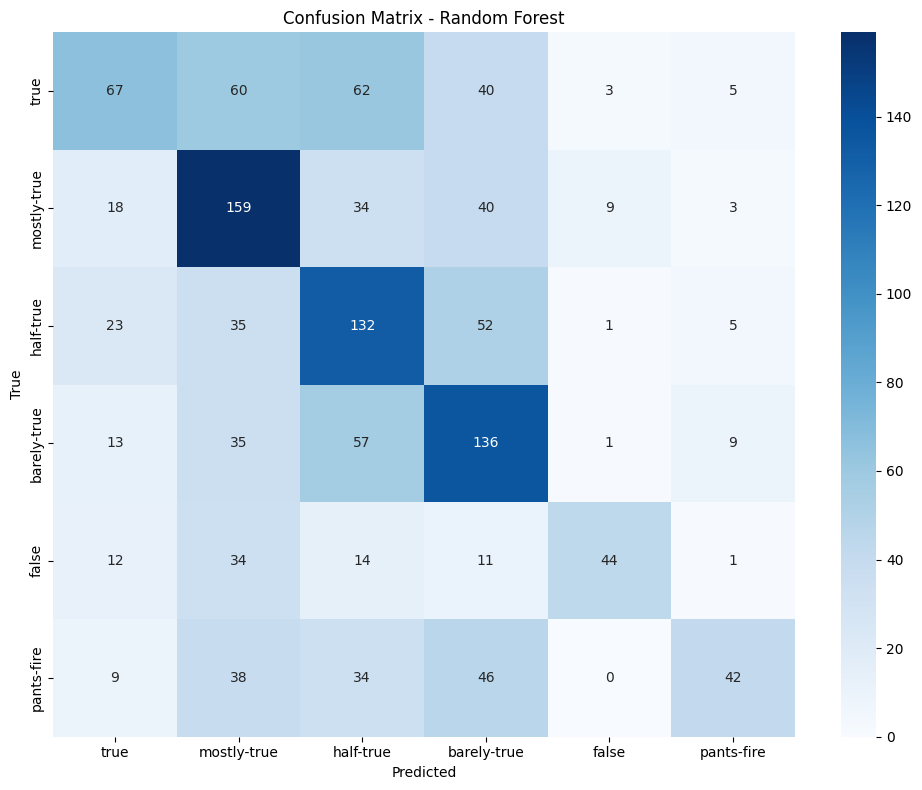

In [16]:
# Prepare features for Random Forest
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df['statement'])
X_valid_tfidf = tfidf.transform(valid_df['statement'])

# Select only numeric features
numeric_features = ['statement_length', 'total_statements'] + count_columns

# Combine TF-IDF features with numeric features
X_train = np.hstack((X_train_tfidf.toarray(), train_df[numeric_features]))
X_valid = np.hstack((X_valid_tfidf.toarray(), valid_df[numeric_features]))

y_train = train_df['label_encoded']
y_valid = valid_df['label_encoded']

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on validation set
y_pred_rf = rf_model.predict(X_valid)

# Define the correct order of labels
correct_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']

# Ensure the LabelEncoder uses this order
le_ordered = LabelEncoder()
le_ordered.fit(correct_order)

# Map the predictions and true labels to the correct order
y_valid_ordered = le_ordered.transform(le.inverse_transform(y_valid))
y_pred_rf_ordered = le_ordered.transform(le.inverse_transform(y_pred_rf))

# Evaluate the model
print("Random Forest Performance:")
print(classification_report(y_valid_ordered, y_pred_rf_ordered, target_names=correct_order))

# Plot confusion matrix
cm = confusion_matrix(y_valid_ordered, y_pred_rf_ordered)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=correct_order, yticklabels=correct_order)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [17]:
#Saving the model and preprocessors
import joblib
import os

# Create a directory to save the model if it doesn't exist
os.makedirs('saved_model', exist_ok=True)

# Save the Random Forest model
rf_model_save_path = 'saved_model/random_forest_fake_news_classifier.joblib'
joblib.dump(rf_model, rf_model_save_path)

# Save the TF-IDF vectorizer
tfidf_save_path = 'saved_model/tfidf_vectorizer.joblib'
joblib.dump(tfidf, tfidf_save_path)

# Save the LabelEncoder
le_save_path = 'saved_model/label_encoder.joblib'
joblib.dump(le, le_save_path)

# Save the list of numeric features
numeric_features_save_path = 'saved_model/numeric_features.joblib'
joblib.dump(numeric_features, numeric_features_save_path)

print(f"Random Forest model saved to {rf_model_save_path}")
print(f"TF-IDF vectorizer saved to {tfidf_save_path}")
print(f"LabelEncoder saved to {le_save_path}")
print(f"Numeric features list saved to {numeric_features_save_path}")

# To load the model and preprocessors later:
# loaded_rf_model = joblib.load(rf_model_save_path)
# loaded_tfidf = joblib.load(tfidf_save_path)
# loaded_le = joblib.load(le_save_path)
# loaded_numeric_features = joblib.load(numeric_features_save_path)

Random Forest model saved to saved_model/random_forest_fake_news_classifier.joblib
TF-IDF vectorizer saved to saved_model/tfidf_vectorizer.joblib
LabelEncoder saved to saved_model/label_encoder.joblib
Numeric features list saved to saved_model/numeric_features.joblib


### Deep Learning Model (BERT)

[Scrivere qua]

In [13]:
# Prepare data for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prepare_bert_input(df):
    encoded_data = tokenizer.batch_encode_plus(
        df['statement'].tolist(),
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=128,
        return_tensors='pt'
    )
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels = torch.tensor(df['label_encoded'].tolist())
    return input_ids, attention_masks, labels

train_inputs, train_masks, train_labels = prepare_bert_input(train_df)
valid_inputs, valid_masks, valid_labels = prepare_bert_input(valid_df)

# Create DataLoaders
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = torch.utils.data.SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=32)

# Initialize BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))
model.cuda()  # Move model to GPU

# Set up optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Training loop
epochs = 4

for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        batch = tuple(t.to('cuda') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    val_accuracy = []
    for batch in valid_dataloader:
        batch = tuple(t.to('cuda') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == b_labels).float().mean()
        val_accuracy.append(accuracy.item())
    
    print(f"Epoch {epoch+1} - Validation Accuracy: {np.mean(val_accuracy):.4f}")

c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=T

Epoch 1 - Validation Accuracy: 0.2584
Epoch 2 - Validation Accuracy: 0.2622
Epoch 3 - Validation Accuracy: 0.2492
Epoch 4 - Validation Accuracy: 0.2622


NameError: name 'b_' is not defined

### Model BERT evaluation

BERT Model Performance:
              precision    recall  f1-score   support

        true       0.24      0.26      0.25       237
 mostly-true       0.27      0.32      0.30       263
   half-true       0.24      0.33      0.28       248
 barely-true       0.28      0.21      0.24       251
       false       0.44      0.23      0.30       116
  pants-fire       0.29      0.21      0.25       169

    accuracy                           0.27      1284
   macro avg       0.29      0.26      0.27      1284
weighted avg       0.28      0.27      0.27      1284



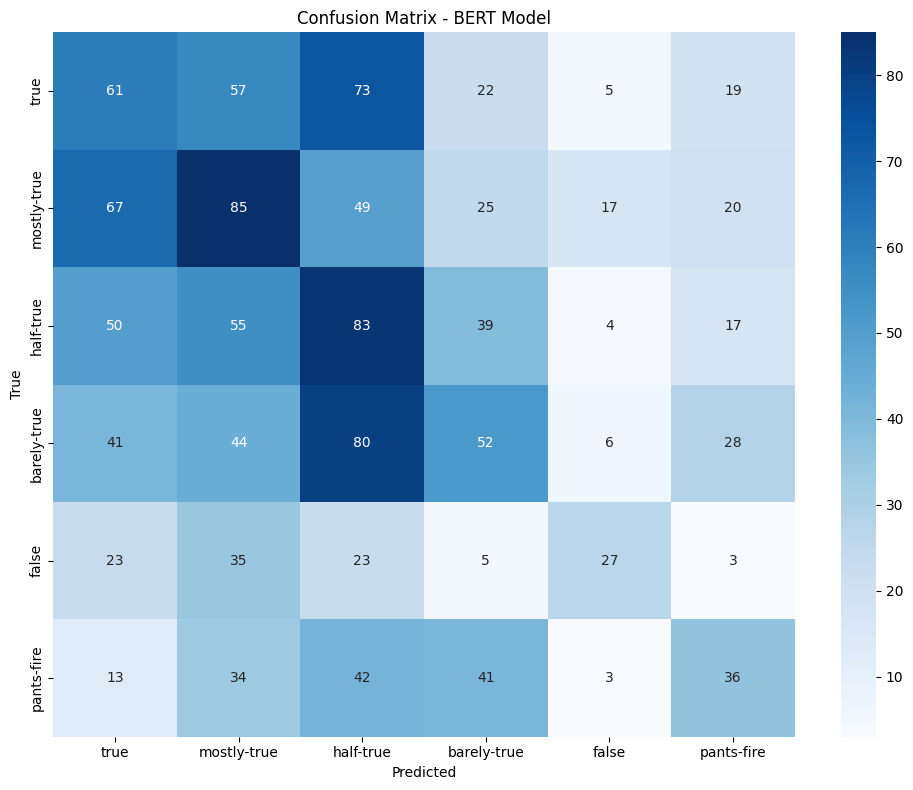

In [15]:
# Evaluate BERT model
model.eval()
bert_predictions = []
true_labels = []

with torch.no_grad():
    for batch in valid_dataloader:
        batch = tuple(t.to('cuda') for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        
        bert_predictions.extend(predictions.cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())

# Convert predictions and true labels back to original label names
bert_predictions = le.inverse_transform(bert_predictions)
true_labels = le.inverse_transform(true_labels)

# Ensure the correct order of labels
correct_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
le_ordered = LabelEncoder()
le_ordered.fit(correct_order)

bert_predictions_ordered = le_ordered.transform(bert_predictions)
true_labels_ordered = le_ordered.transform(true_labels)

# Print classification report
print("BERT Model Performance:")
print(classification_report(true_labels_ordered, bert_predictions_ordered, target_names=correct_order))

# Plot confusion matrix
cm = confusion_matrix(true_labels_ordered, bert_predictions_ordered)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=correct_order, yticklabels=correct_order)
plt.title('Confusion Matrix - BERT Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [14]:
import os
import torch
from transformers import BertForSequenceClassification

# Assuming your model is called 'model' and is already trained

# Create a directory to save the model
os.makedirs('saved_model', exist_ok=True)

# Save the model
model_save_path = 'saved_model/bert_fake_news_classifier.pt'
torch.save(model.state_dict(), model_save_path)

# Save the configuration
model.config.save_pretrained('saved_model')

print(f"Model saved to {model_save_path}")


Model saved to saved_model/bert_fake_news_classifier.pt


### DL ROBERTA

In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import os

# Set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Load the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def prepare_roberta_input(df, tokenizer, max_length=128):
    encoded_data = tokenizer.batch_encode_plus(
        df['statement'].tolist(),
        add_special_tokens=True,
        return_attention_mask=True,
        padding='max_length',
        max_length=max_length,
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels = torch.tensor(df['label_encoded'].tolist())
    return input_ids, attention_masks, labels

# Prepare data
train_inputs, train_masks, train_labels = prepare_roberta_input(train_df, tokenizer)
valid_inputs, valid_masks, valid_labels = prepare_roberta_input(valid_df, tokenizer)

# Create DataLoaders
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)


c:\Users\alexc\anaconda3\envs\TorchP11\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [22]:
# Set up RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(le.classes_))
model.to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
def format_time(elapsed):
    return str(int(elapsed // 3600)) + 'h:' + str(int((elapsed % 3600) // 60)) + 'm:' + str(int(elapsed % 60)) + 's'

for epoch in range(epochs):
    print(f'\n======== Epoch {epoch+1} / {epochs} ========')
    print('Training...')
    
    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training", unit="batch")):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        if (step + 1) % 100 == 0:
            elapsed = format_time(time.time() - t0)
            remaining = format_time((time.time() - t0) / (step + 1) * (len(train_dataloader) - (step + 1)))
            print(f'Batch {step + 1}/{len(train_dataloader)} | Elapsed: {elapsed} | Remaining: {remaining}')
    
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")
    
    print("\nRunning Validation...")
    model.eval()
    val_accuracy = []
    
    for batch in tqdm(valid_dataloader, desc="Validation", unit="batch"):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == b_labels).float().mean()
        val_accuracy.append(accuracy.item())
    
    print(f"Validation Accuracy: {np.mean(val_accuracy):.4f}")
    print(f"Total training time: {format_time(time.time() - t0)}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 4 ========
Training...


Training:  32%|███▏      | 101/320 [00:15<00:31,  6.84batch/s]

Batch 100/320 | Elapsed: 0h:0m:15s | Remaining: 0h:0m:33s


Training:  63%|██████▎   | 201/320 [00:29<00:17,  6.68batch/s]

Batch 200/320 | Elapsed: 0h:0m:29s | Remaining: 0h:0m:17s


Training:  94%|█████████▍| 301/320 [00:44<00:02,  6.79batch/s]

Batch 300/320 | Elapsed: 0h:0m:44s | Remaining: 0h:0m:2s


Training: 100%|██████████| 320/320 [00:47<00:00,  6.77batch/s]


Average training loss: 1.7460

Running Validation...


Validation: 100%|██████████| 41/41 [00:01<00:00, 23.65batch/s]


Validation Accuracy: 0.2660
Total training time: 0h:0m:48s

======== Epoch 2 / 4 ========
Training...


Training:  32%|███▏      | 101/320 [00:14<00:31,  6.86batch/s]

Batch 100/320 | Elapsed: 0h:0m:14s | Remaining: 0h:0m:32s


Training:  63%|██████▎   | 201/320 [00:29<00:17,  6.86batch/s]

Batch 200/320 | Elapsed: 0h:0m:29s | Remaining: 0h:0m:17s


Training:  94%|█████████▍| 301/320 [00:44<00:02,  6.80batch/s]

Batch 300/320 | Elapsed: 0h:0m:43s | Remaining: 0h:0m:2s


Training: 100%|██████████| 320/320 [00:46<00:00,  6.82batch/s]


Average training loss: 1.6707

Running Validation...


Validation: 100%|██████████| 41/41 [00:01<00:00, 23.04batch/s]


Validation Accuracy: 0.2881
Total training time: 0h:0m:48s

======== Epoch 3 / 4 ========
Training...


Training:  32%|███▏      | 101/320 [00:14<00:32,  6.72batch/s]

Batch 100/320 | Elapsed: 0h:0m:14s | Remaining: 0h:0m:32s


Training:  63%|██████▎   | 201/320 [00:29<00:17,  6.74batch/s]

Batch 200/320 | Elapsed: 0h:0m:29s | Remaining: 0h:0m:17s


Training:  94%|█████████▍| 301/320 [00:44<00:02,  6.71batch/s]

Batch 300/320 | Elapsed: 0h:0m:44s | Remaining: 0h:0m:2s


Training: 100%|██████████| 320/320 [00:47<00:00,  6.71batch/s]


Average training loss: 1.5727

Running Validation...


Validation: 100%|██████████| 41/41 [00:01<00:00, 23.44batch/s]


Validation Accuracy: 0.2851
Total training time: 0h:0m:49s

======== Epoch 4 / 4 ========
Training...


Training:  32%|███▏      | 101/320 [00:14<00:31,  6.91batch/s]

Batch 100/320 | Elapsed: 0h:0m:14s | Remaining: 0h:0m:32s


Training:  63%|██████▎   | 201/320 [00:29<00:17,  6.79batch/s]

Batch 200/320 | Elapsed: 0h:0m:29s | Remaining: 0h:0m:17s


Training:  94%|█████████▍| 301/320 [00:44<00:02,  6.83batch/s]

Batch 300/320 | Elapsed: 0h:0m:44s | Remaining: 0h:0m:2s


Training: 100%|██████████| 320/320 [00:47<00:00,  6.78batch/s]


Average training loss: 1.4794

Running Validation...


Validation: 100%|██████████| 41/41 [00:01<00:00, 23.20batch/s]

Validation Accuracy: 0.2797
Total training time: 0h:0m:48s


In [23]:
# Create a directory to save the model
os.makedirs('saved_roberta_model', exist_ok=True)

# Save the model
model_save_path = 'saved_roberta_model/roberta_fake_news_classifier.pt'
torch.save(model.state_dict(), model_save_path)

# Save the configuration
model.config.save_pretrained('saved_roberta_model')

# Save the tokenizer
tokenizer.save_pretrained('saved_roberta_model')

print(f"Model saved to {model_save_path}")

Model saved to saved_roberta_model/roberta_fake_news_classifier.pt


In [24]:
def evaluate_model(model, dataloader, le):
    model.eval()
    predictions = []
    true_labels = []
    
    for batch in tqdm(dataloader, desc="Evaluating", unit="batch"):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)
        
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)
        
        predictions.extend(batch_predictions.cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())
    
    # Convert predictions and true labels back to original label names
    predictions = le.inverse_transform(predictions)
    true_labels = le.inverse_transform(true_labels)
    
    return predictions, true_labels

# Evaluate the model
predictions, true_labels = evaluate_model(model, valid_dataloader, le)

# Ensure the correct order of labels
correct_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
le_ordered = LabelEncoder()
le_ordered.fit(correct_order)

predictions_ordered = le_ordered.transform(predictions)
true_labels_ordered = le_ordered.transform(true_labels)

# Print classification report
print("RoBERTa Model Performance:")
print(classification_report(true_labels_ordered, predictions_ordered, target_names=correct_order))

# Plot confusion matrix
cm = confusion_matrix(true_labels_ordered, predictions_ordered)

Evaluating: 100%|██████████| 41/41 [00:01<00:00, 23.27batch/s]

RoBERTa Model Performance:
              precision    recall  f1-score   support

        true       0.27      0.15      0.19       237
 mostly-true       0.32      0.30      0.31       263
   half-true       0.25      0.31      0.28       248
 barely-true       0.30      0.38      0.33       251
       false       0.34      0.25      0.29       116
  pants-fire       0.23      0.27      0.25       169

    accuracy                           0.28      1284
   macro avg       0.28      0.28      0.27      1284
weighted avg       0.28      0.28      0.28      1284



# (Task 1b) Text Classification

Single-Label Multi-Class

Preprocessing

Class distribution in training set:
binary_label
False    0.644727
True     0.355273
Name: proportion, dtype: float64

Class distribution in validation set:
binary_label
False    0.672897
True     0.327103
Name: proportion, dtype: float64

Class distribution in test set:
binary_label
False    0.64562
True     0.35438
Name: proportion, dtype: float64


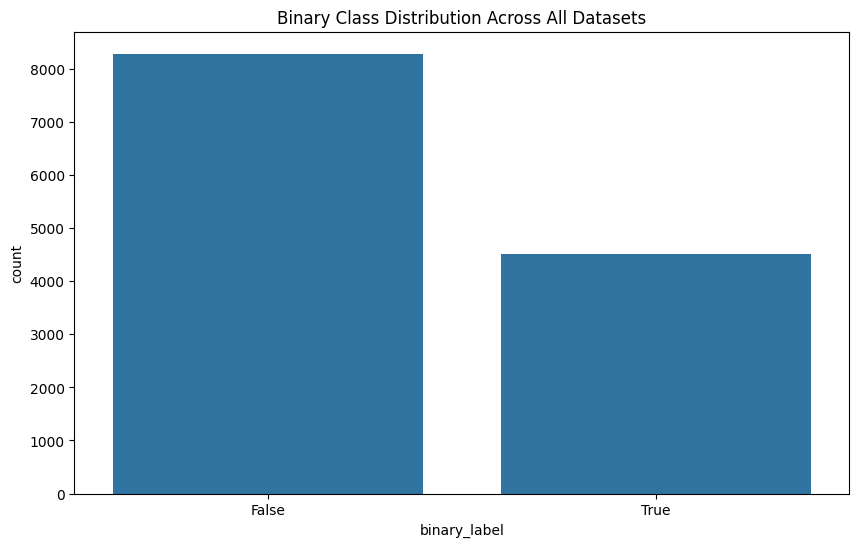

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Assuming you have already loaded your datasets into train_df, valid_df, and test_df

def binarize_labels(label):
    if label in ['true', 'mostly-true']:
        return 'True'
    else:
        return 'False'

# Apply binary labeling to all datasets
train_df['binary_label'] = train_df['label'].apply(binarize_labels)
valid_df['binary_label'] = valid_df['label'].apply(binarize_labels)
test_df['binary_label'] = test_df['label'].apply(binarize_labels)

# Encode binary labels
le = LabelEncoder()
train_df['label_encoded'] = le.fit_transform(train_df['binary_label'])
valid_df['label_encoded'] = le.transform(valid_df['binary_label'])
test_df['label_encoded'] = le.transform(test_df['binary_label'])

# Display class distribution
print("Class distribution in training set:")
print(train_df['binary_label'].value_counts(normalize=True))

print("\nClass distribution in validation set:")
print(valid_df['binary_label'].value_counts(normalize=True))

print("\nClass distribution in test set:")
print(test_df['binary_label'].value_counts(normalize=True))

# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='binary_label', data=pd.concat([train_df, valid_df, test_df]))
plt.title('Binary Class Distribution Across All Datasets')
plt.show()

In [27]:
# Print some sample rows to verify the transformation
print("\nSample rows from the training set:")
print(train_df[['statement', 'label', 'binary_label', 'label_encoded']].head(10))


Sample rows from the training set:
                                           statement        label  \
0  Says the Annies List political group supports ...        false   
1  When did the decline of coal start? It started...    half-true   
2  Hillary Clinton agrees with John McCain "by vo...  mostly-true   
3  Health care reform legislation is likely to ma...        false   
4  The economic turnaround started at the end of ...    half-true   
5  The Chicago Bears have had more starting quart...         true   
6  Jim Dunnam has not lived in the district he re...  barely-true   
7  I'm the only person on this stage who has work...    half-true   
8  However, it took $19.5 million in Oregon Lotte...    half-true   
9  Says GOP primary opponents Glenn Grothman and ...  mostly-true   

  binary_label  label_encoded  
0        False              0  
1        False              0  
2         True              1  
3        False              0  
4        False              0  
5         Tr

In [28]:
# Save the label encoder
import joblib
joblib.dump(le, 'binary_label_encoder.joblib')
print("\nLabel Encoder saved as 'binary_label_encoder.joblib'")


Label Encoder saved as 'binary_label_encoder.joblib'


### Traditional ML - Random Forest Classifier

In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import nltk
from nltk.corpus import stopwords
import string

# Download the stopwords list if you haven't already
nltk.download('stopwords')

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# 1. Preprocessing and Training

# Assuming train_df, valid_df, and test_df are already loaded and preprocessed for binary classification

# Apply text preprocessing
combined_df = pd.concat([train_df, valid_df])
combined_df['processed_statement'] = combined_df['statement'].apply(preprocess_text)
test_df['processed_statement'] = test_df['statement'].apply(preprocess_text)

# TF-IDF Vectorization with stop words removal
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_combined_tfidf = tfidf.fit_transform(combined_df['processed_statement'])
X_test_tfidf = tfidf.transform(test_df['processed_statement'])

# Add additional numeric features
numeric_features = ['statement_length', 'total_statements']

# Ensure these features are present in your dataframes
combined_df['statement_length'] = combined_df['statement'].str.len()
combined_df['total_statements'] = combined_df[['barely_true_counts', 'false_counts', 'half_true_counts', 
                                               'mostly_true_counts', 'pants_on_fire_counts']].sum(axis=1)

test_df['statement_length'] = test_df['statement'].str.len()
test_df['total_statements'] = test_df[['barely_true_counts', 'false_counts', 'half_true_counts', 
                                       'mostly_true_counts', 'pants_on_fire_counts']].sum(axis=1)

# Combine TF-IDF features with numeric features
X_combined = np.hstack((X_combined_tfidf.toarray(), combined_df[numeric_features]))
X_test = np.hstack((X_test_tfidf.toarray(), test_df[numeric_features]))

y_combined = combined_df['label_encoded']
y_test = test_df['label_encoded']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [35]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_combined, y_combined)

RandomForestClassifier(random_state=42)

In [36]:
# 2. Model Evaluation

# Make predictions on test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Print classification report
print("Random Forest Performance (Binary Classification with Stop Words Removal):")
print(classification_report(y_test, y_pred, target_names=['False', 'True']))

Random Forest Performance (Binary Classification with Stop Words Removal):
              precision    recall  f1-score   support

       False       0.67      0.91      0.78       818
        True       0.55      0.19      0.29       449

    accuracy                           0.66      1267
   macro avg       0.61      0.55      0.53      1267
weighted avg       0.63      0.66      0.60      1267



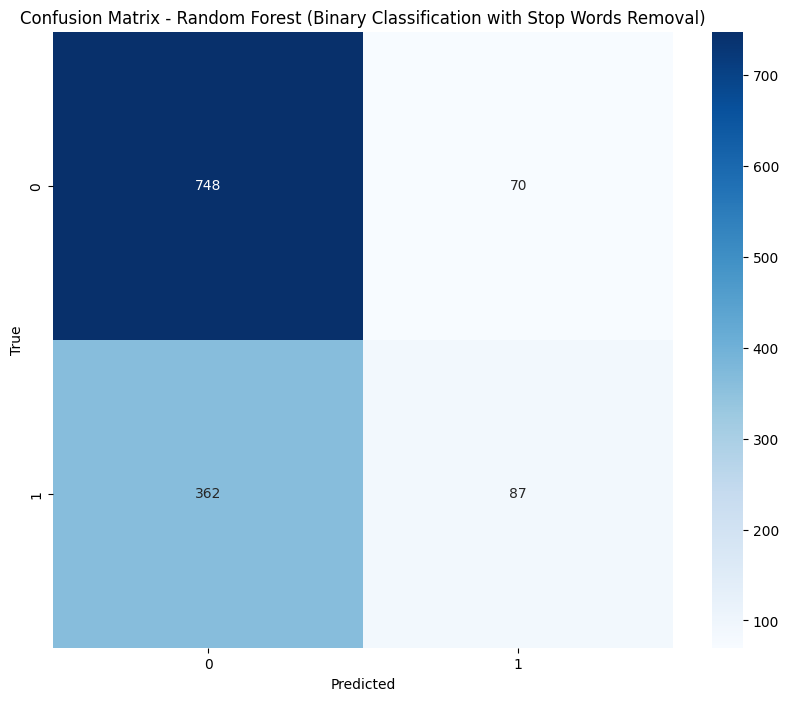

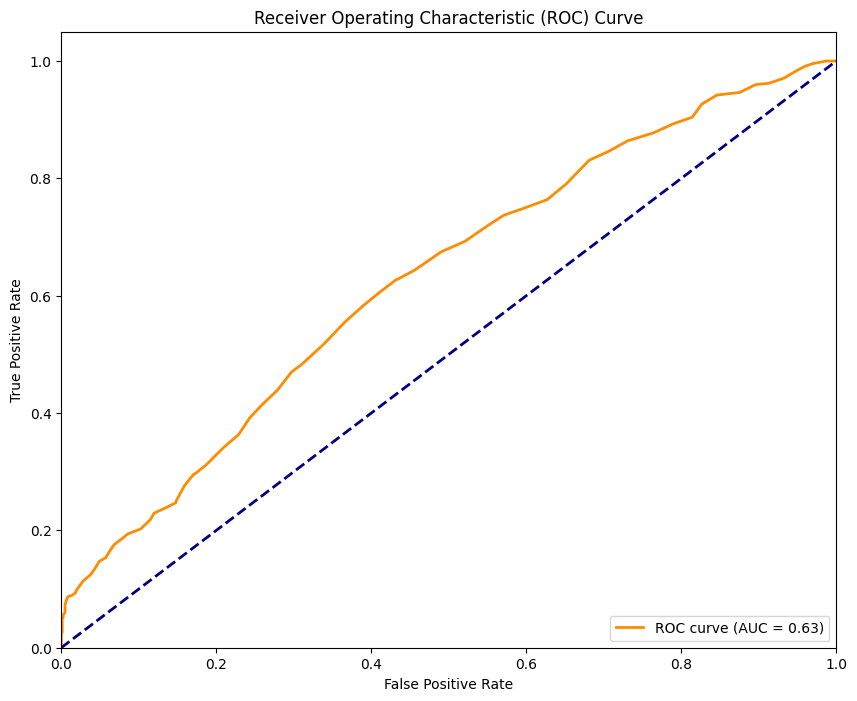

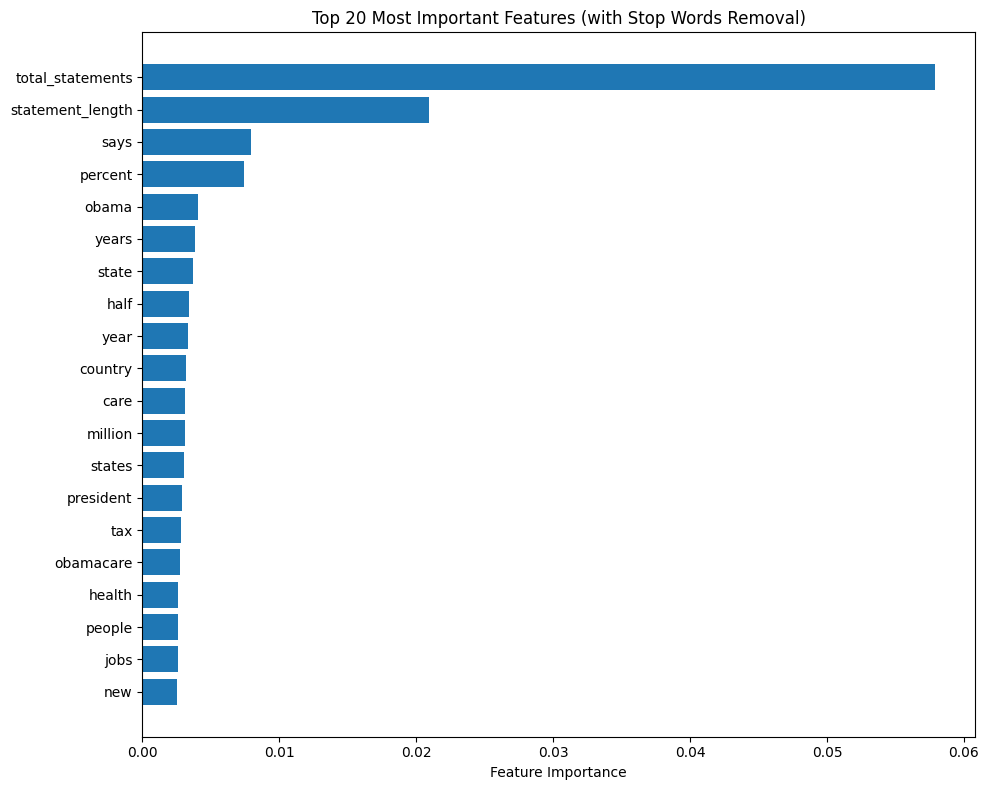

In [37]:
# 3. Visualize Model Performance

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Binary Classification with Stop Words Removal)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
feature_importance = rf_model.feature_importances_
feature_names = tfidf.get_feature_names_out().tolist() + numeric_features
sorted_idx = np.argsort(feature_importance)
top_20_idx = sorted_idx[-20:]

plt.figure(figsize=(10, 8))
plt.barh(range(20), feature_importance[top_20_idx])
plt.yticks(range(20), [feature_names[i] for i in top_20_idx])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (with Stop Words Removal)')
plt.tight_layout()
plt.show()

In [33]:
# Save the model and vectorizer
joblib.dump(rf_model, 'random_forest_binary_classifier.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer_binary.joblib')
print("Model and vectorizer saved.")

Model and vectorizer saved.


# ANDREA CONTINUA DA QUI

# (Task 2) Topic Modelling

Usiamo LDA direi?